In [1]:
!pip install pingouin pycirclize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=fe527165679854f95a25e515ae320367b2dc91ff03ab57e174728b9e69dcd888
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
from pathlib import Path
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as sstats
import pingouin

In [4]:
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
plt.rcParams['font.size'] = 7
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["svg.fonttype"] = "path"

In [ ]:
# this is for Zhen-Qi, change it when you run it
data_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/My Documents/Research/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Figures")

In [5]:
# this is for Haley
data_dir = Path("/content/gdrive/MyDrive/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Data")
figs_dir = Path("/content/gdrive/MyDrive/Manuscript_JAMAPsychiatry_EP_MEND_PLS/Figures")

In [6]:
ep_pls_result = h5py.File(data_dir / "EP_pls_result.hdf5")

In [7]:
ep_pls_all = pd.read_csv(data_dir / "EP_PLS_all.csv")
post_hoc = ep_pls_all[["src_subject_id", "cohort", "age_demeaned", "sex", "dup", "med_equiv_current", "dx", "dx_code"]].rename({
    "src_subject_id": "ID",
    "age_demeaned": "age",
    "med_equiv_current": "med",
})
with h5py.File(data_dir / "EP_pls_result.hdf5") as f:
    post_hoc['LC1_brain'] = f["results"]["x_scores"][:, 0]
    post_hoc['LC1_behv'] = f["results"]["y_scores"][:, 0]

In [8]:
group_names = ["Schizophrenia", "Schizoaffective disorder", "Psychotic mood disorders"]
group_names_short = ["Schizophrenia", "Schizoaffective\ndisorder", "Psychotic mood\ndisorders"]

In [9]:
# Define a function to set the values of column "A" based on column "B"
def set_value(row):
    if row['dx'] in [295.90, 295.40, 298.80, 297.10]:
        return group_names[0]
    elif row["dx"] in [295.70]:
        return group_names[1]
    elif row['dx'] in [296.24, 296.44, 296.89, 296.54, 296.34, 296.40, 296.53]:
        return group_names[2]

# Apply the function to create column "A"
post_hoc['group'] = post_hoc.apply(set_value, axis=1)

In [10]:
post_hoc['group'] = pd.Categorical(post_hoc['group'], categories=group_names, ordered=True)
post_hoc['group_code'] = post_hoc['group'].cat.codes

In [11]:
x_scores_grouped = [post_hoc['LC1_brain'].to_numpy()[np.where(post_hoc["group"] == _)[0]] for _ in group_names]
y_scores_grouped = [post_hoc['LC1_behv'].to_numpy()[np.where(post_hoc["group"] == _)[0]] for _ in group_names]

In [12]:
from matplotlib.colors import ListedColormap, to_rgb, to_hex
pal_bgo_3 = ["#31A9E7", "#305861", "#F19100"]
cmap_bgo_3 = ListedColormap([to_rgb(_) for _ in pal_bgo_3])

In [13]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

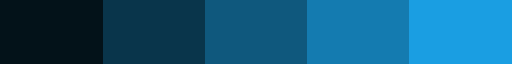

In [14]:
ListedColormap([to_hex(scale_lightness(to_rgb(pal_bgo_3[0]), _)) for _ in [0.1, 0.3, 0.5, 0.7, 0.9]])

In [15]:
score_corr_r, score_corr_p = sstats.pearsonr(ep_pls_result["results"]["x_scores"][:, 0], ep_pls_result["results"]["y_scores"][:, 0])

from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(ep_pls_result["results"]["x_scores"][:, 0].reshape(-1, 1), ep_pls_result["results"]["y_scores"][:, 0].reshape(-1, 1))
b = reg.intercept_
m = reg.coef_[0]

In [16]:
plt.close('all')

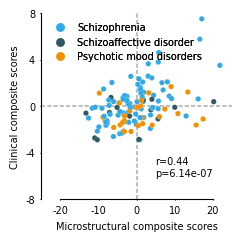

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), layout="constrained")
scatter = ax.scatter(ep_pls_result["results"]["x_scores"][:, 0], ep_pls_result["results"]["y_scores"][:, 0],
           s=15, c=post_hoc['group_code'], cmap=cmap_bgo_3, linewidths=0.1, edgecolors='white')
ax.axvline(x=0, c="silver", zorder=0, ls=(0, (2, 1)))
ax.axhline(y=0, c="silver", zorder=0, ls=(0, (2, 1)))

reg_x = np.arange(-20, np.max(ep_pls_result["results"]["x_scores"][:, 0]), 0.1)
#ax.plot(reg_x, m * reg_x + b, color="gray", zorder=0.5)

ax.set(xlim=(-25, 25), ylim=(-8, 8), xticks=[-20, -10, 0, 10, 20], yticks=[-8, -4, 0, 4, 8],
       xlabel="Microstructural composite scores", ylabel="Clinical composite scores")

ax.text(5, -6, f"r={score_corr_r:.2f}\np={score_corr_p:.2e}")

sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=1)

handles, previous_labels = scatter.legend_elements()
legend = ax.legend(handles=handles, labels=group_names, loc="upper left", bbox_to_anchor=(0, 1.0), frameon=False)
ax.add_artist(legend)
fig.savefig(figs_dir / "hcpep_score_corr.svg")

In [ ]:
def plot_raincloud(x, ax):
    pos = np.array([1, 2, 3])
    v1 = ax.violinplot(x, positions=pos+0.2,
                    showmeans=False, showextrema=False, showmedians=False)

    for b, c in zip(v1['bodies'], pal_bgo_3):
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
        b.set_facecolor(c)
        b.set_linewidth(0)

    b1 = ax.boxplot(x, positions=pos, patch_artist=True, widths=0.15)

    for item in ['boxes']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, facecolor=c, edgecolor=to_hex(scale_lightness(to_rgb(c), 0.75)))
    for item in ['medians']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, color=c)
    for item in ['whiskers', 'caps']:
        for i, patch in enumerate(b1[item]):
            c = pal_bgo_3[int(i/2)]
            plt.setp(patch, color=to_hex(scale_lightness(to_rgb(c), 0.75)))
    for item in ['fliers']:
        for patch, c in zip(b1[item], pal_bgo_3):
            plt.setp(patch, markeredgecolor=c)

    e1 = ax.eventplot(x, orientation="vertical", lineoffsets=pos-0.2, linelengths=0.1, colors=pal_bgo_3)

    return v1, b1, e1

In [ ]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print(pingouin.ttest(x_scores_grouped[i], x_scores_grouped[j]))

              T        dof alternative     p-val          CI95%   cohen-d  \
T-test  0.12912  15.643472   two-sided  0.898908  [-5.14, 5.81]  0.046065   

        BF10     power  
T-test  0.29  0.052835  
              T        dof alternative     p-val          CI95%   cohen-d  \
T-test -1.02254  45.638492   two-sided  0.311915  [-4.73, 1.54]  0.229897   

         BF10     power  
T-test  0.361  0.179054  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.685446  21.123926   two-sided  0.500516  [-7.76, 3.91]  0.244138   

         BF10     power  
T-test  0.381  0.112589  


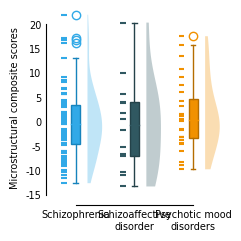

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), layout="constrained")
v1, b1, e1 = plot_raincloud(x_scores_grouped, ax)

ax.set(ylim=(-17, 23), yticks=[-15, -10, -5, 0, 5, 10, 15, 20], xticklabels=group_names_short,
       ylabel="Microstructural composite scores")
sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

fig.savefig(figs_dir / "hcpep_x_scores.svg")

In [ ]:
for i, j in [(0, 1), (0, 2), (1, 2)]:
    print(pingouin.ttest(y_scores_grouped[i], y_scores_grouped[j]))

               T        dof alternative     p-val         CI95%   cohen-d  \
T-test  2.622393  24.193071   two-sided  0.014874  [0.22, 1.88]  0.584717   

         BF10     power  
T-test  4.625  0.514061  
               T        dof alternative     p-val         CI95%   cohen-d  \
T-test  3.439487  82.863801   two-sided  0.000915  [0.42, 1.59]  0.591469   

          BF10    power  
T-test  34.644  0.75948  
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.111838  22.517963   two-sided  0.911942  [-0.87, 0.78]  0.038787   

         BF10     power  
T-test  0.319  0.051534  


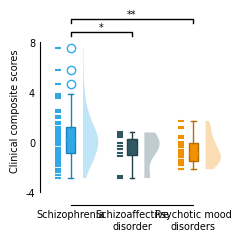

In [ ]:
fig, ax = plt.subplots(figsize=(2.3, 2.3), layout="constrained")
v1, b1, e1 = plot_raincloud(y_scores_grouped, ax)

ax.set(ylim=(-5, 10), yticks=[-4, 0, 4, 8], xticklabels=group_names_short,
        ylabel="Clinical composite scores")
sns.despine(top=True, right=True, trim=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both',length=0)

y1, y2, h = 8.5, 9.5, 0.3
ax.plot([1, 1, 2, 2], [y1, y1+h, y1+h, y1], lw=1, c="k")
ax.text(1.5, y1+h, "*", ha='center', va='bottom', color="k")
ax.plot([1, 1, 3, 3], [y2, y2+h, y2+h, y2], lw=1, c="k")
ax.text(2, y2+h, "**", ha='center', va='bottom', color="k")

fig.savefig(figs_dir / "hcpep_y_scores.svg")

In [ ]:
ep_pls_loadings = h5py.File(data_dir / "EP_pls_loadings.hdf5")

In [ ]:
ep_pls_xload = ep_pls_loadings["results/y_loadings"][:, 0]
ep_pls_xload_resort = np.argsort(-1 * ep_pls_loadings["results/y_loadings"][:, 0])
ep_pls_xload_top_idx = np.where(np.abs(sstats.zscore(ep_pls_xload)) > 2)[0]
ep_pls_xload_sq_top_idx = np.where(np.abs(sstats.zscore(ep_pls_xload ** 2)) > 2)[0]
ep_pls_xload_err = (ep_pls_loadings["results/bootres/y_loadings_ci"][:, 0, 1]- ep_pls_loadings["results/bootres/y_loadings_ci"][:, 0, 0]) / 2
ep_pls_xload_top_resort = np.argsort(-1 * ep_pls_loadings["results/y_loadings"][ep_pls_xload_top_idx, 0])
ep_pls_xload_sq_top_resort = np.argsort(-1 * ep_pls_loadings["results/y_loadings"][ep_pls_xload_sq_top_idx, 0])

In [ ]:
diff_pred_names = np.loadtxt(data_dir / "JHU_labels.txt", delimiter="\t", dtype=str)

In [ ]:
diff_pred_names_optimized = ["(" + _.replace("_", ") ") for _ in diff_pred_names]
diff_pred_names_optimized = np.array(diff_pred_names_optimized)

In [ ]:
diff_pred_names_optimized = ["(" + _.replace("_", ") ") for _ in diff_pred_names]
for i in range(len(diff_pred_names_optimized)):
    curr_name = diff_pred_names_optimized[i]
    curr_new = curr_name.split(" ")
    if len(curr_name) >= 40:
        curr_new.insert(-3, "\n")
    elif 40 > len(curr_name) > 25:
        curr_new.insert(-2, "\n")
    diff_pred_names_optimized[i] = " ".join(curr_new)
diff_pred_names_optimized = np.array(diff_pred_names_optimized)

In [ ]:
# fig, ax = plt.subplots(figsize=(2.5, 16))
# ax.barh(np.arange(len(ep_pls_xload_resort)), ep_pls_xload[ep_pls_xload_resort],
#         xerr=ep_pls_xload_err[ep_pls_xload_resort])
# ax.set(yticks=np.arange(len(ep_pls_xload_resort)), yticklabels=diff_pred_names_optimized[ep_pls_xload_resort])
# ax.invert_yaxis()
# sns.despine(top=True, right=True, ax=ax)
# ax.tick_params(axis=u'both', which=u'both', length=0)

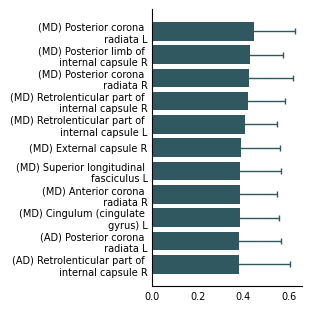

In [ ]:
fig, ax = plt.subplots(figsize=(3.0, 3.0), layout="constrained")
ax.barh(np.arange(len(ep_pls_xload_sq_top_resort)), ep_pls_xload[ep_pls_xload_sq_top_idx][ep_pls_xload_sq_top_resort],
        xerr=ep_pls_xload_err[ep_pls_xload_sq_top_idx][ep_pls_xload_sq_top_resort], color=pal_bgo_3[1], height=0.8,
        error_kw=dict(ecolor=pal_bgo_3[1], lw=1, capsize=2, capthick=1))
ax.set(xticks=[0, 0.2, 0.4, 0.6],
       #yticks=np.arange(len(ep_pls_xload_sq_top_resort)), yticklabels=diff_pred_names_optimized[ep_pls_xload_sq_top_idx][ep_pls_xload_sq_top_resort])
       yticks=np.arange(len(ep_pls_xload_sq_top_resort)), yticklabels=diff_pred_names_optimized[ep_pls_xload_sq_top_idx][ep_pls_xload_sq_top_resort])

ax.invert_yaxis()
sns.despine(top=True, right=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

fig.savefig(figs_dir / "hcpep_xload.svg")

In [ ]:
3# fig, ax = plt.subplots(figsize=(3, 3), layout="constrained")
# ax.barh(np.arange(len(ep_pls_xload_top_resort)), ep_pls_xload[ep_pls_xload_top_idx][ep_pls_xload_top_resort],
#         xerr=ep_pls_xload_err[ep_pls_xload_top_idx][ep_pls_xload_top_resort], color=pal_bgo_3[0], height=0.75,
#         error_kw=dict(ecolor=pal_bgo_3[1], lw=1, capsize=2, capthick=1))
# ax.set(xticks=[-0.6, -0.4, -0.2, 0],
#        yticks=np.arange(len(ep_pls_xload_top_resort)), yticklabels=diff_pred_names_optimized[ep_pls_xload_top_idx][ep_pls_xload_top_resort])
# ax.invert_yaxis()
# sns.despine(top=True, right=True, ax=ax)
# ax.tick_params(axis=u'both', which=u'both', length=0)

3

In [19]:
ep_pls_yload = ep_pls_result["results/y_loadings"][:, 0]
ep_pls_yload_err = (ep_pls_result["results/bootres/y_loadings_ci"][:, 0, 1]- ep_pls_result["results/bootres/y_loadings_ci"][:, 0, 0]) / 2

ep_pls_yload_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][:, 0])
ep_pls_yload_top_idx = np.where(
    (np.abs(sstats.zscore(ep_pls_yload)) > 1)
    & ((np.abs(ep_pls_yload)-ep_pls_yload_err)>0)
    )[0]
ep_pls_yload_sq_top_idx = np.where(
    (np.abs(sstats.zscore(ep_pls_yload ** 2)) > 1)
    & ((np.abs(ep_pls_yload)-ep_pls_yload_err)>0)
    )[0]
ep_pls_yload_top_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][ep_pls_yload_top_idx, 0])
ep_pls_yload_sq_top_resort = np.argsort(-1 * ep_pls_result["results/y_loadings"][ep_pls_yload_sq_top_idx, 0])

In [20]:
ep_pls_yload_sq_top_idx

array([ 7, 10, 12, 13, 17, 33])

In [21]:
ep_scores = pd.read_csv(data_dir / "EP_scores.csv")

In [22]:
score_dimension_to_color = {"pos": "#5C554A", "neg": "#31A9E7", "gen": "#345662", "mania": "#F19100"}

In [23]:
ep_scores["text_color"] = ep_scores["dimension"].map(score_dimension_to_color)

In [24]:
for i in range(len(ep_scores)):
    curr_name = ep_scores.loc[i, "description"]
    curr_new = curr_name.split(" ")
    if len(curr_name) >= 40:
        curr_new.insert(-3, "\n")
    elif 40 > len(curr_name) > 23:
        curr_new.insert(-2, "\n")
    ep_scores.loc[i, "description"] = " ".join(curr_new)

In [26]:
temp = pd.DataFrame(columns=['symptoms', 'coef', 'se'])
temp['symptoms'] = ep_scores["description"].to_numpy()
temp['coef'] = ep_pls_yload
temp['se'] = ep_pls_yload_err

temp


,symptoms,coef,se
0,Delusions,-0.113631,0.174186
1,Conceptual Organization,-0.043916,0.164650
2,Hallucinatory Behavior,0.094642,0.187063
3,Excitement,0.058556,0.191289
4,Grandiosity,-0.012608,0.202921
5,\n Suspiciousness/Persecution,0.016096,0.171685
6,Hostility,-0.001120,0.198443
7,Blunted Affect,0.199383,0.196347
8,Emotional Withdrawal,0.143901,0.186904
9,Poor Rapport,0.083063,0.194928


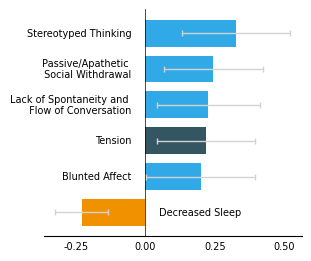

In [ ]:
fig, ax = plt.subplots(figsize=(3.0, 2.5), layout="constrained")

plot_x = np.arange(len(ep_pls_yload_sq_top_resort))
plot_y = ep_pls_yload[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
plot_error = ep_pls_yload_err[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
plot_y_ticklabels = ep_scores["description"].to_numpy()[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
plot_y_ticklabels_color = ep_scores["text_color"].to_numpy()[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]
plot_y_pos = np.where(plot_y>0)[0]
plot_y_neg = np.where(plot_y<0)[0]

ax.axvline(x=0, c="black", lw=0.5)

ax.barh(plot_x, plot_y, xerr=plot_error, color=plot_y_ticklabels_color, height=0.75,
        error_kw=dict(ecolor="lightgray", lw=1, capsize=2, capthick=1))
ax.set(xticks=[-0.25, 0, 0.25, 0.5], yticks=plot_x, yticklabels=[])
ax.invert_yaxis()
sns.despine(top=True, right=True, left=True, ax=ax)
ax.tick_params(axis=u'both', which=u'both', length=0)

for i in plot_y_pos:
    ax.text(-0.05, plot_x[i], plot_y_ticklabels[i], ha="right", va="center",
            color="k")
for i in plot_y_neg:
    ax.text(0.05, plot_x[i], plot_y_ticklabels[i], ha="left", va="center",
            color="k")

fig.savefig(figs_dir / "hcpep_yload.svg")

In [17]:
from pycirclize import Circos

In [18]:
ep_scores["yload"] = ep_pls_yload
ep_pls_yload_sq_top_score_names = ep_scores["description"].to_numpy()[ep_pls_yload_sq_top_idx][ep_pls_yload_sq_top_resort]

NameError: ignored

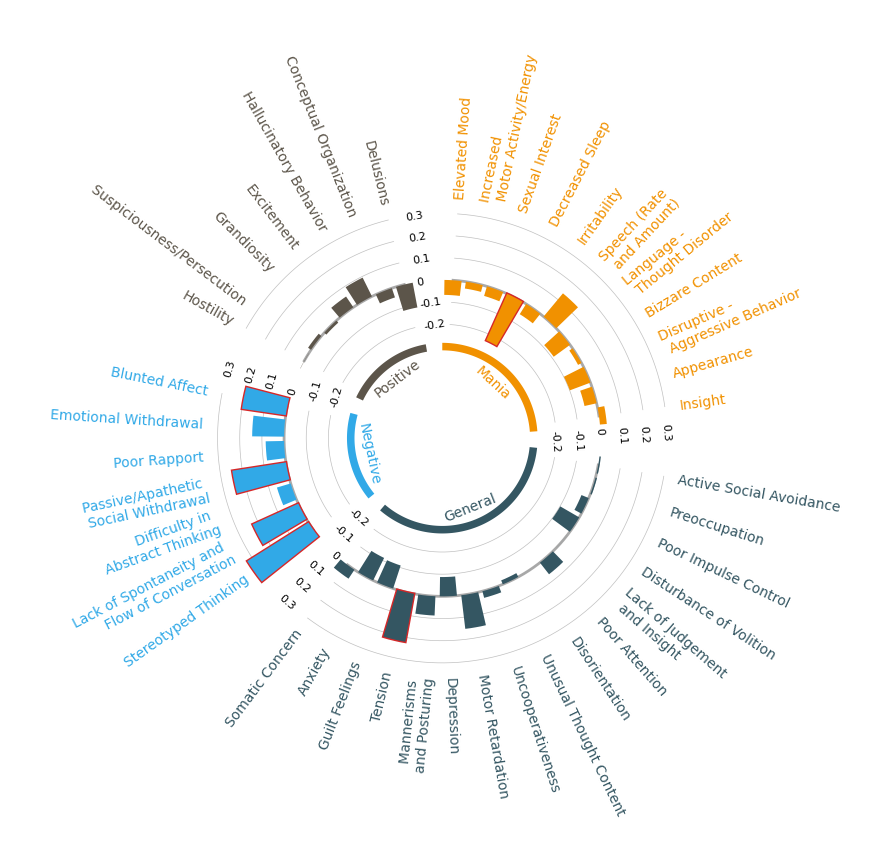

In [ ]:
with matplotlib.rc_context({"svg.fonttype": "path"}):
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'}, layout="constrained")

    sectors = {"Mania": 11, "General": 16, "Negative": 7, "Positive": 7}
    circos = Circos(
        sectors, space=10,
        sector2clockwise = {"Positive": False, "Negative": False, "General": False, "Mania": True}
        )

    for sector, dim in zip(circos.sectors, ["mania", "gen", "neg", "pos"]):

        sector.rect(r_lim=(35, 38), color=score_dimension_to_color[dim])
        sector.text(f"{sector.name}", r=27, size=10, color=score_dimension_to_color[dim])

        curr_ep_scores = ep_scores[ep_scores["dimension"]==dim]
        plot_x = np.arange(len(curr_ep_scores)) + 0.5
        plot_y = curr_ep_scores["yload"].to_numpy()
        plot_ylabel = curr_ep_scores["description"].to_numpy()
        vmin, vmax = -0.23, 0.33

        track = sector.add_track((40, 95), r_pad_ratio=0.1)
        # track.axis()
        track.xticks(plot_x, plot_ylabel, label_orientation="vertical", tick_length=0,
                    text_kws={"color": score_dimension_to_color[dim]}, label_size=10)
        track.yticks(y=[-0.2, -0.1, 0, 0.1, 0.2, 0.3], vmin=vmin, vmax=vmax,
                    labels=[-0.2, -0.1, 0, 0.1, 0.2, 0.3], tick_length=0)

        track.line(plot_x, [0]*len(plot_x), vmin=vmin, vmax=vmax, arc=True, color="darkgray", lw=2, zorder=1)
        for i in [-0.2, -0.1, 0.1, 0.2, 0.3]:
            track.line(plot_x, [i]*len(plot_x), vmin=vmin, vmax=vmax, arc=True, color="silver", zorder=1)
        track.bar(plot_x, plot_y, vmin=vmin, vmax=vmax, color=score_dimension_to_color[dim], zorder=3)

        plot_ylabel_sig_idx = [i for i, _ in enumerate(plot_ylabel) if _ in ep_pls_yload_sq_top_score_names]
        for curr_idx in plot_ylabel_sig_idx:
            track.bar([plot_x[curr_idx]], [plot_y[curr_idx]], vmin=vmin, vmax=vmax, zorder=2, linewidth=2, edgecolor="tab:red")

    fig = circos.plotfig(ax=ax)
    fig.savefig(figs_dir / "hcpep_yload_circle.svg")